## Compare PCA weights spatially

### Outline

> 1. Preprocess

> 2. PCA

> 3. Analyse PC weights

In [4]:
'''
Dependencies
'''
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sparse
import warnings 
from scipy import integrate
import seaborn as sns
warnings.simplefilter('ignore')
from sklearn import metrics
from sklearn import decomposition
from sklearn.preprocessing import normalize
from scipy.stats import ks_2samp
import scipy.io as sio
import os
import importlib
import rutils
from pyaldata import *
from rutils import *
from tqdm import tqdm

'''
Plotting aesthetics
'''
sns.set_style('white')
sns.set_context('notebook', font_scale=1.35)

#sns.light_palette(color='electric blue', input='xkcd')
cmap = sns.light_palette(color='electric blue', input='xkcd', as_cmap=True)
div_cmap = sns.diverging_palette(250, 150, as_cmap=True)

cs = ['#DC7253', '#264653', '#3DC1AB', '#92F0E4', '#CEE2DA', '#DC7253', '#4D7399', '#CDBCA5']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cs)

'''
Magic commands
'''
%autoreload 5
%config InlineBackend.figure_format = 'retina'

[xkcd colors](https://xkcd.com/color/rgb/)

## Load data

In [5]:
'''
Insert path and filename 
'''
path = '/Users/Daphne/Data/'  
fname = 'Chewie_CO_VR_2016-10-06.mat' 
df = mat2dataframe(path+fname, shift_idx_fields=True)

In [6]:
df.shape

(774, 24)

## 1 Preprocess 

### 1.1 Combine time bins

In [7]:
td = combine_time_bins(df, n_bins=3)

### 1.2 Remove low firing neurons

In [8]:
td = remove_low_firing_neurons(td, signal='M1_spikes', threshold=5)
td = remove_low_firing_neurons(td, signal='PMd_spikes', threshold=5)

### 1.3 Transform signals

In [9]:
td = transform_signal(td, signal='M1_spikes',  transformations='sqrt')
td = transform_signal(td, signal='PMd_spikes', transformations='sqrt')

### 1.4 Merge signals

In [10]:
td = merge_signals(td, ['M1_spikes', 'PMd_spikes'], 'both_spikes')

### 1.5 Compute firing rates from spike trains

Add firing rates for `M1_spikes`, `PMd_spikes` and `both_spikes`

In [11]:
# works on '_spikes' fields and automatically divides by bin_size
td = add_firing_rates(td, 'smooth')

In [12]:
td.head()

,monkey,date,task,target_direction,trial_id,result,bin_size,perturbation,perturbation_info,epoch,...,acc,force,M1_spikes,M1_unit_guide,PMd_spikes,PMd_unit_guide,both_spikes,M1_rates,PMd_rates,both_rates
0,Chewie,10-06-2016,CO,-2.356194,1,R,0.03,VR,-0.52,BL,...,"[[25.292273710326047, 23.948816622289783], [26...","[[0.3854857746577438, -0.18448026169727955], [...","[[1.0, 1.0, 1.0, 1.4142135623730951, 0.0, 0.0,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[1.0, 1.0, 1.0, 1.4142135623730951, 0.0, 0.0,...","[[10.371933240023875, 15.773752026832693, 12.3...","[[8.902097383481504, 8.635500399091704, 6.2947...","[[10.371933240023875, 15.773752026832693, 12.3..."
1,Chewie,10-06-2016,CO,1.570796,2,R,0.03,VR,-0.52,BL,...,"[[33.67115720999763, 79.08430607100303], [23.7...","[[0.1778157378731141, 0.12542049016429982], [0...","[[1.0, 1.0, 0.0, 1.0, 1.0, 1.4142135623730951,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.414213562373...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[1.0, 1.0, 0.0, 1.0, 1.0, 1.4142135623730951,...","[[11.264847879857852, 14.03731918590052, 8.031...","[[5.401818786808815, 14.407176539761242, 13.14...","[[11.264847879857852, 14.03731918590052, 8.031..."
2,Chewie,10-06-2016,CO,0.785398,3,R,0.03,VR,-0.52,BL,...,"[[1.6623846773446733, -20.151668914256682], [4...","[[0.2833417683274762, -0.1285513884878812], [0...","[[1.0, 1.0, 1.4142135623730951, 0.0, 0.0, 1.41...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[1.0, 1.4142135623730951, 1.0, 0.0, 0.0, 0.0,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[1.0, 1.0, 1.4142135623730951, 0.0, 0.0, 1.41...","[[10.371933240023875, 16.66666666666667, 11.84...","[[16.66666666666667, 10.949669788579067, 7.742...","[[10.371933240023875, 16.66666666666667, 11.84..."
3,Chewie,10-06-2016,CO,3.141593,4,R,0.03,VR,-0.52,BL,...,"[[-10.229040288523265, -22.654816986306813], [...","[[0.08675043530985374, 0.03658922221440793], [...","[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 1.4142135623730951,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8929146398339769, 8.635500399091704, 10.26...","[[0.8929146398339769, 7.742585759257727, 5.401...","[[0.8929146398339769, 8.635500399091704, 10.26..."
4,Chewie,10-06-2016,CO,-1.570796,5,R,0.03,VR,-0.52,BL,...,"[[55.86100520057167, -6.586410543949703], [45....","[[0.2054977133197953, -0.12485484173352068], [...","[[0.0, 0.0, 1.0, 1.4142135623730951, 1.0, 1.0,...","[[5, 1], [5, 2], [9, 1], [9, 2], [13, 1], [13,...","[[1.0, 1.0, 0.0, 1.4142135623730951, 0.0, 0.0,...","[[1, 1], [1, 2], [7, 4], [7, 5], [8, 2], [8, 3...","[[0.0, 0.0, 1.0, 1.4142135623730951, 1.0, 1.0,...","[[8.031166267574964, 8.924080907408943, 13.144...","[[15.773752026832693, 16.66666666666667, 0.892...","[[8.031166267574964, 8.924080907408943, 13.144..."


### 1.6 Select data from Baseline epoch

Select only those rows from the baseline epoch `'BL'`

In [20]:
td = td.loc[df['epoch'] == 'BL']

In [21]:
td.shape

(217, 28)

## 2 Do Principal Component Analysis

### 2.1 Do PCA on both arrays 

`both_rates`

In [22]:
which_dim = 0 

m1pmd_loadings, m1pmd_var = getPCA(rates=td['both_rates'])

w = m1pmd_loadings[:, which_dim] 

This is the eigenvector associated with the first PC. 

Each element represents a loading, namely how much (the weight) each original neuron contributes to the corresponding principal component.

In [23]:
w.shape # total number of neurons

(143,)

In [24]:
M = sort_pcs_by(m1pmd_loadings, td['M1_spikes'][0], by=0)

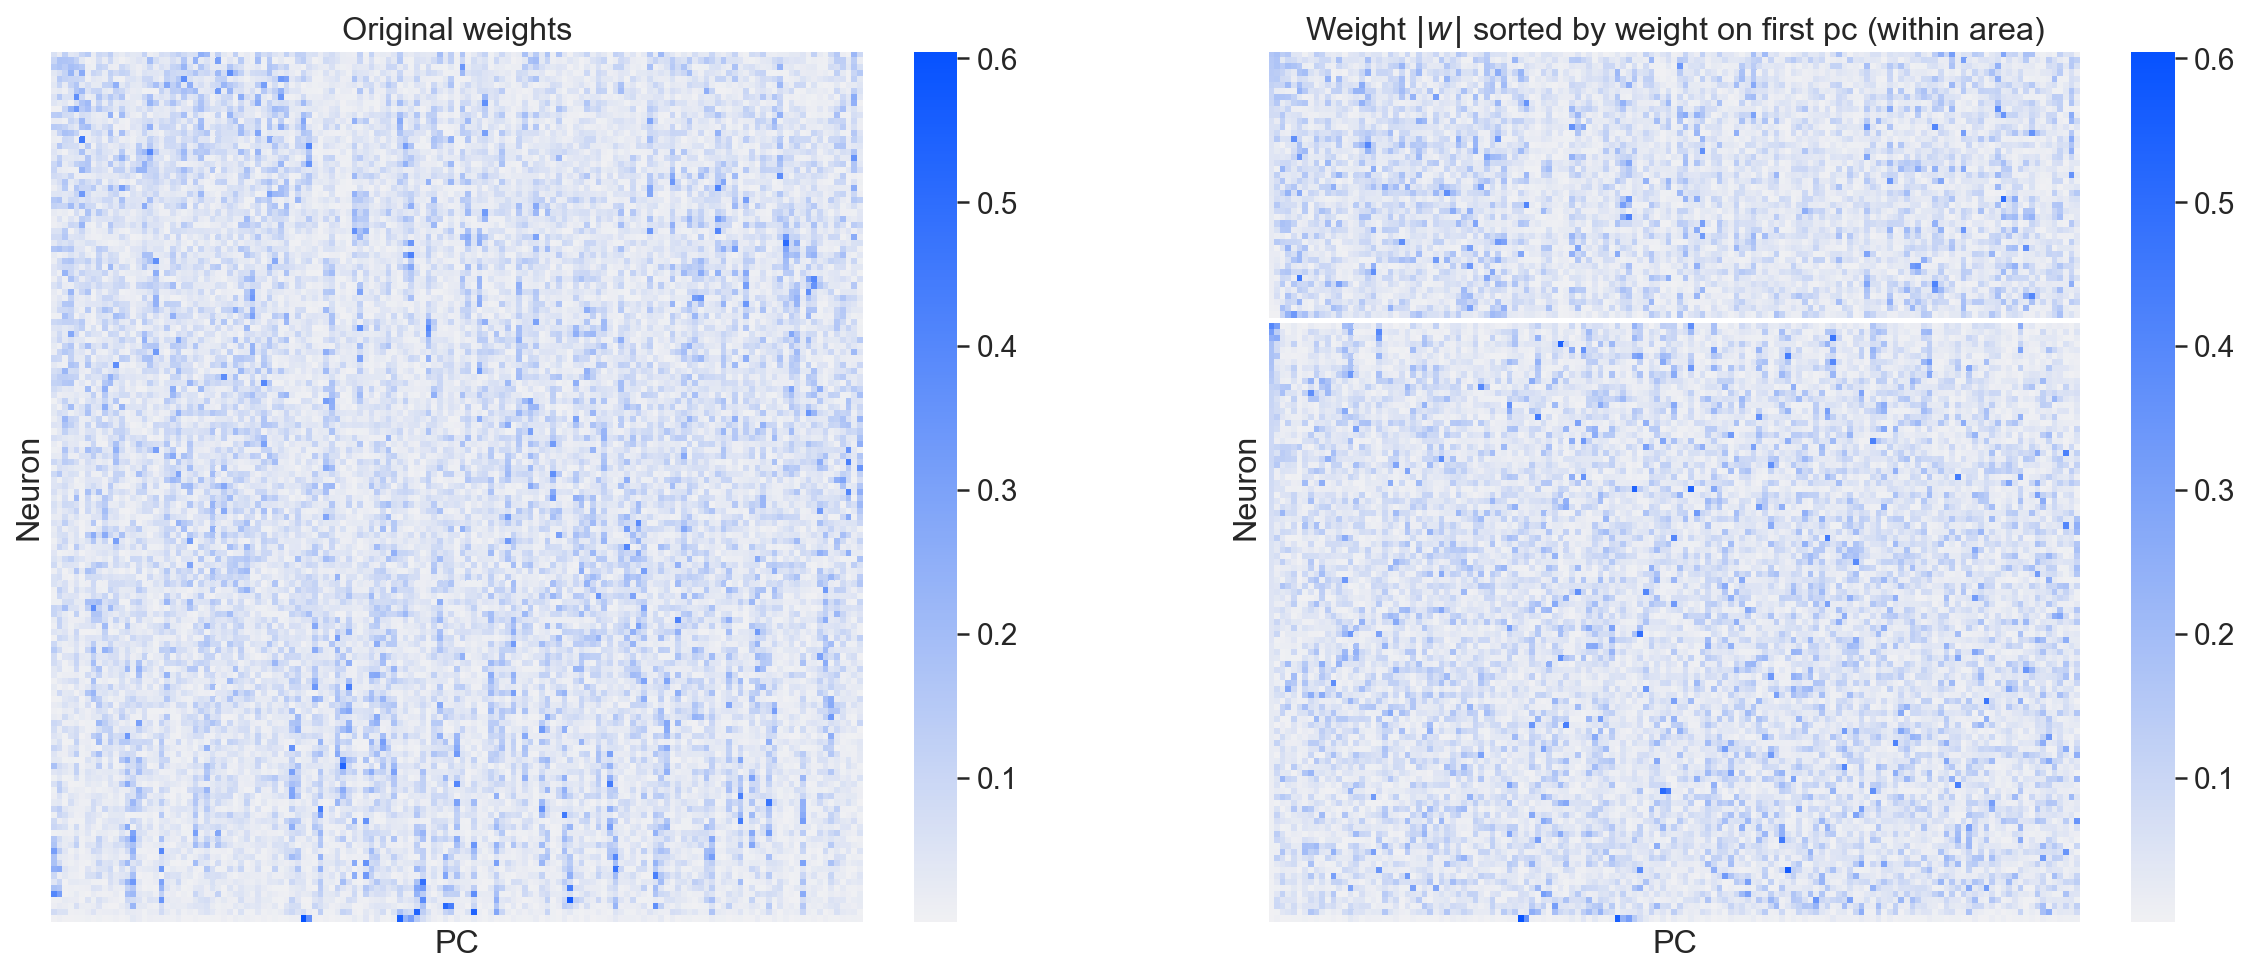

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(abs(m1pmd_loadings), cbar=True, ax=ax1, cmap=cmap, xticklabels=False, yticklabels=False)
ax1.set_title(r'Original weights')
ax1.set_xlabel('PC')
ax1.set_ylabel('Neuron')

sns.heatmap(M, cbar=True, ax=ax2, cmap=cmap, xticklabels=False, yticklabels=False)
ax2.set_title(r'Weight $|w|$ sorted by weight on first pc (within area)')
ax2.set_xlabel('PC')
ax2.set_ylabel('Neuron');

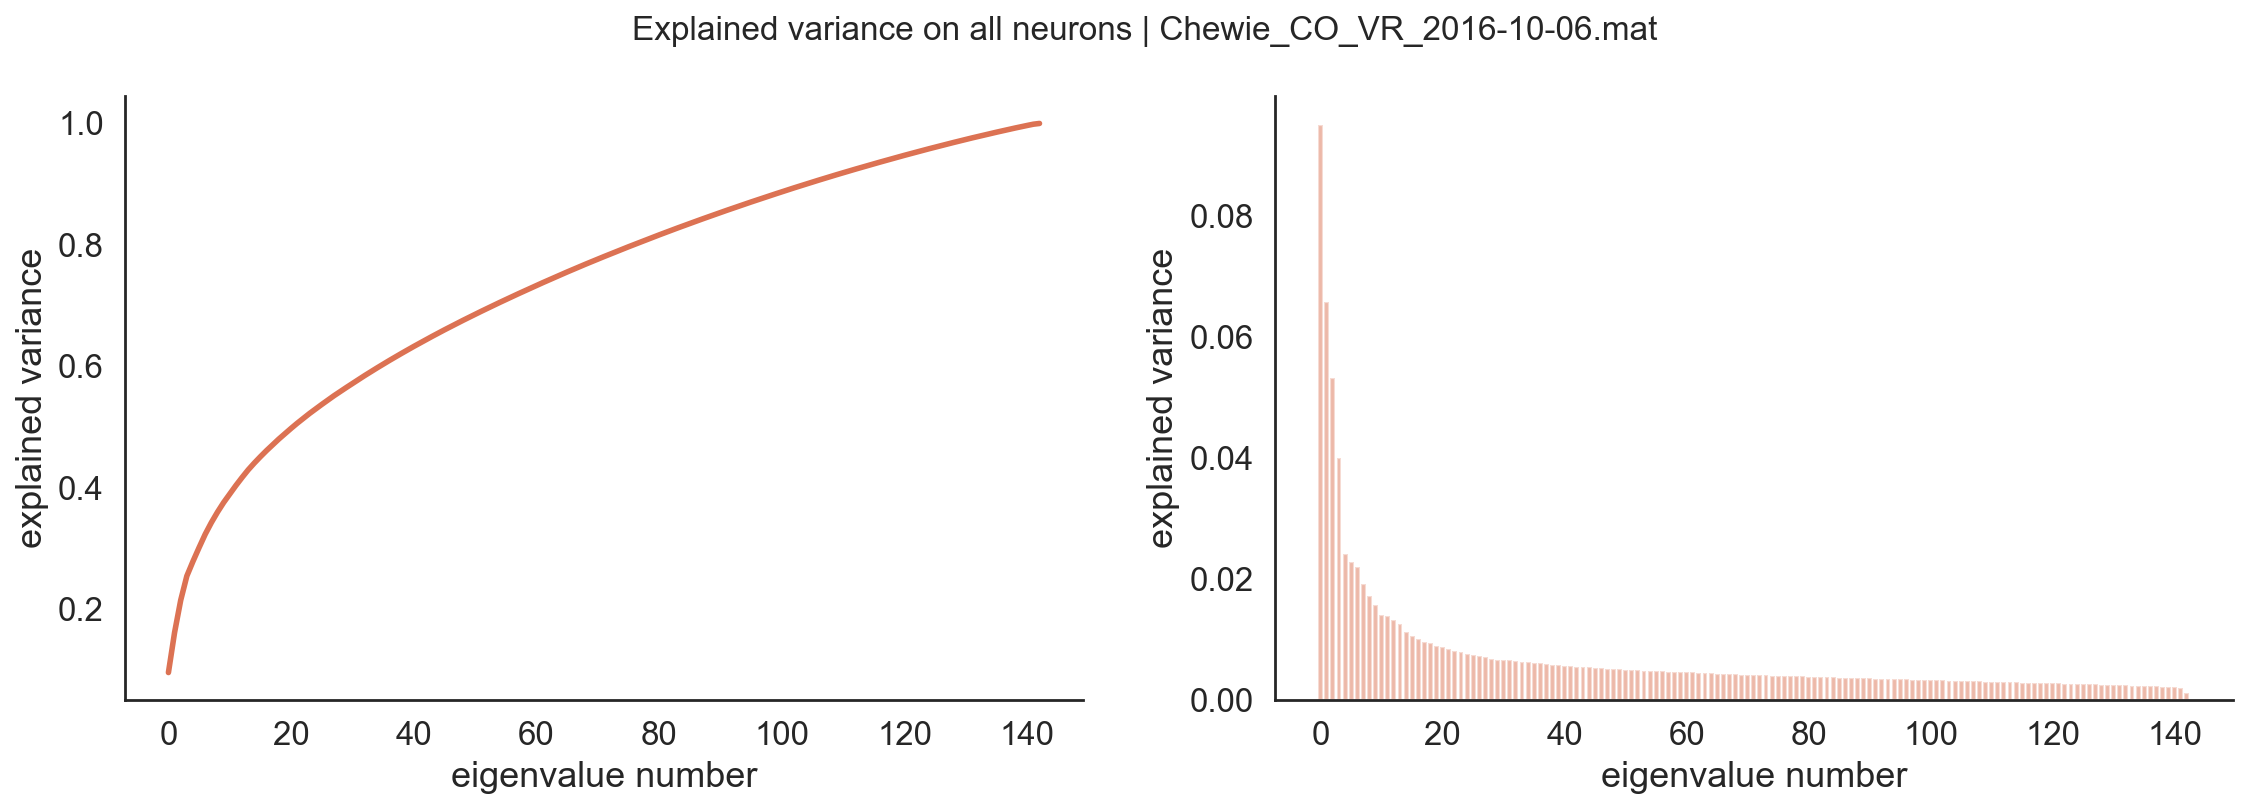

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5), dpi=80)
fig.suptitle(f'Explained variance on all neurons | {fname}', fontsize=15)
ax1.plot(m1pmd_var.cumsum(), lw=2.5)
ax1.set_xlabel('eigenvalue number')
ax1.set_ylabel('explained variance')

ax2.bar(range(0, len(m1pmd_var)), m1pmd_var, alpha=0.5, align='center')
ax2.set_xlabel('eigenvalue number')
ax2.set_ylabel('explained variance')
sns.despine(left=False, bottom=False);

### 2.2 Do PCA on PMd array

`PMd_rates`

In [27]:
pmd_loadings, pmd_var = getPCA(rates=td['PMd_rates']) 

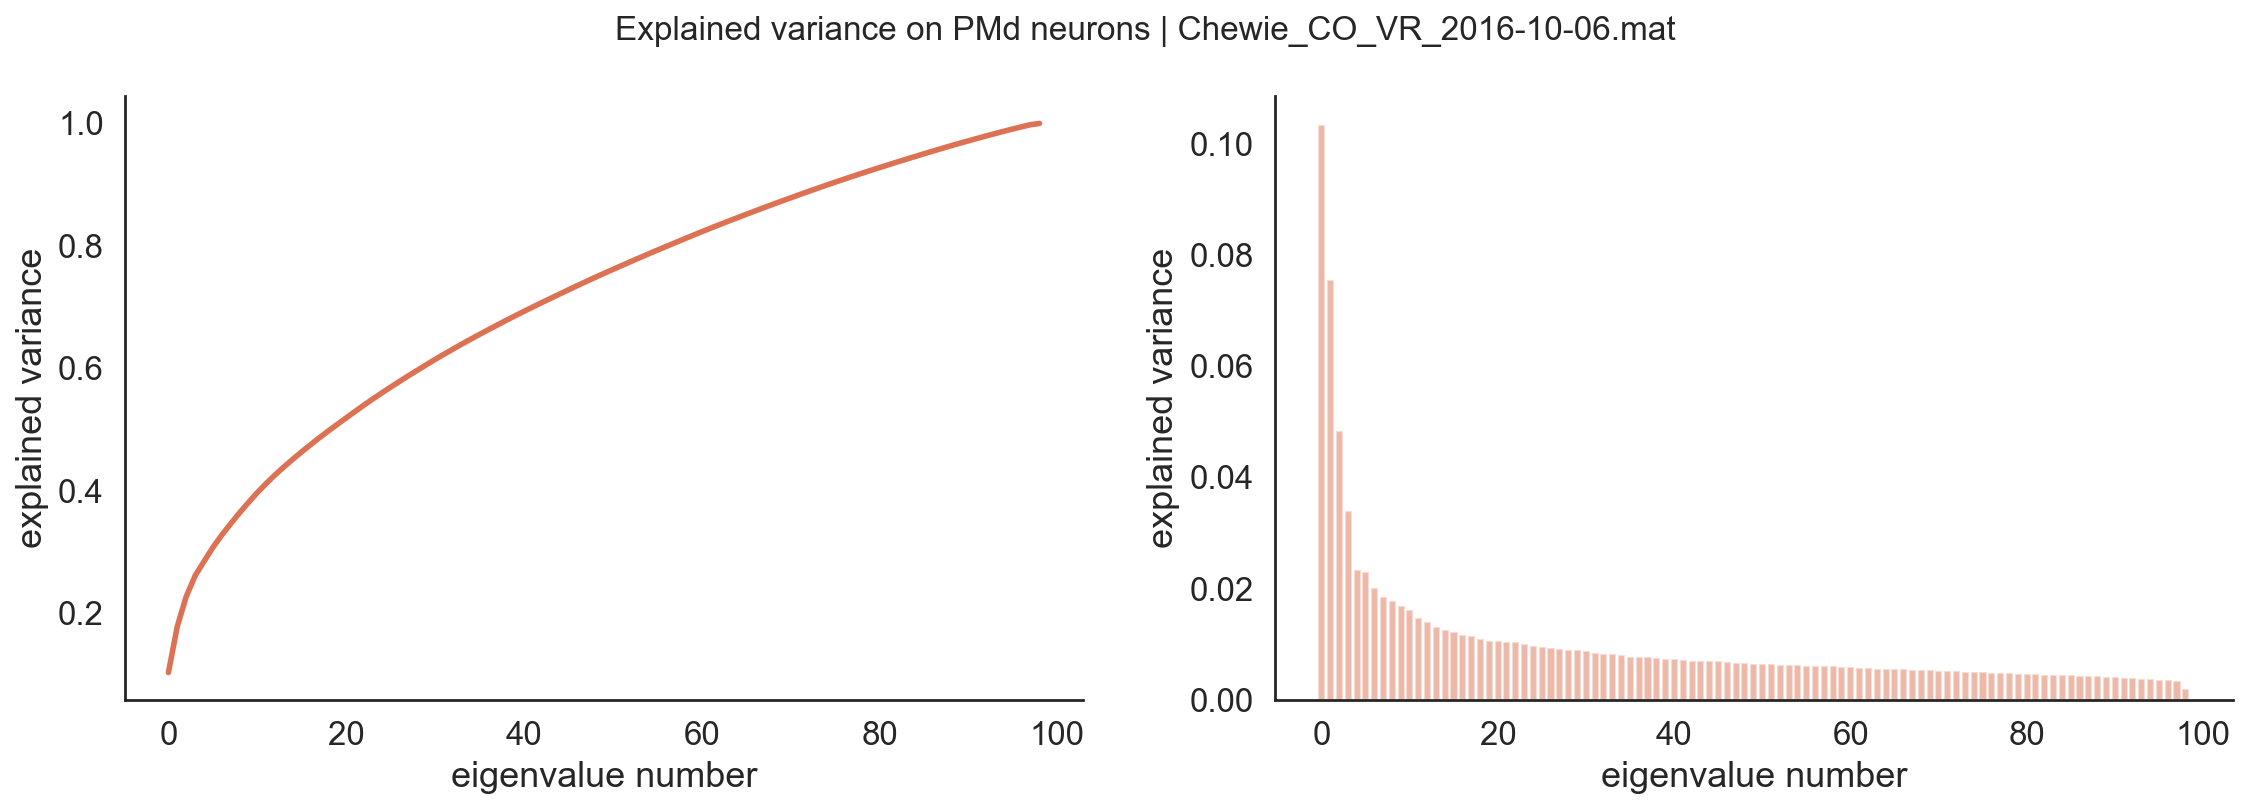

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5), dpi=80)
fig.suptitle(f'Explained variance on PMd neurons | {fname}', fontsize=15)
ax1.plot(pmd_var.cumsum(), lw=2.5)
ax1.set_xlabel('eigenvalue number')
ax1.set_ylabel('explained variance')

ax2.bar(range(0, len(pmd_var)), pmd_var, alpha=0.5, align='center')
ax2.set_xlabel('eigenvalue number')
ax2.set_ylabel('explained variance')
sns.despine();

### 2.3 Do PCA on M1 array

`M1_rates`

In [29]:
m1_loadings, m1_var = getPCA(rates=td['M1_rates']) 

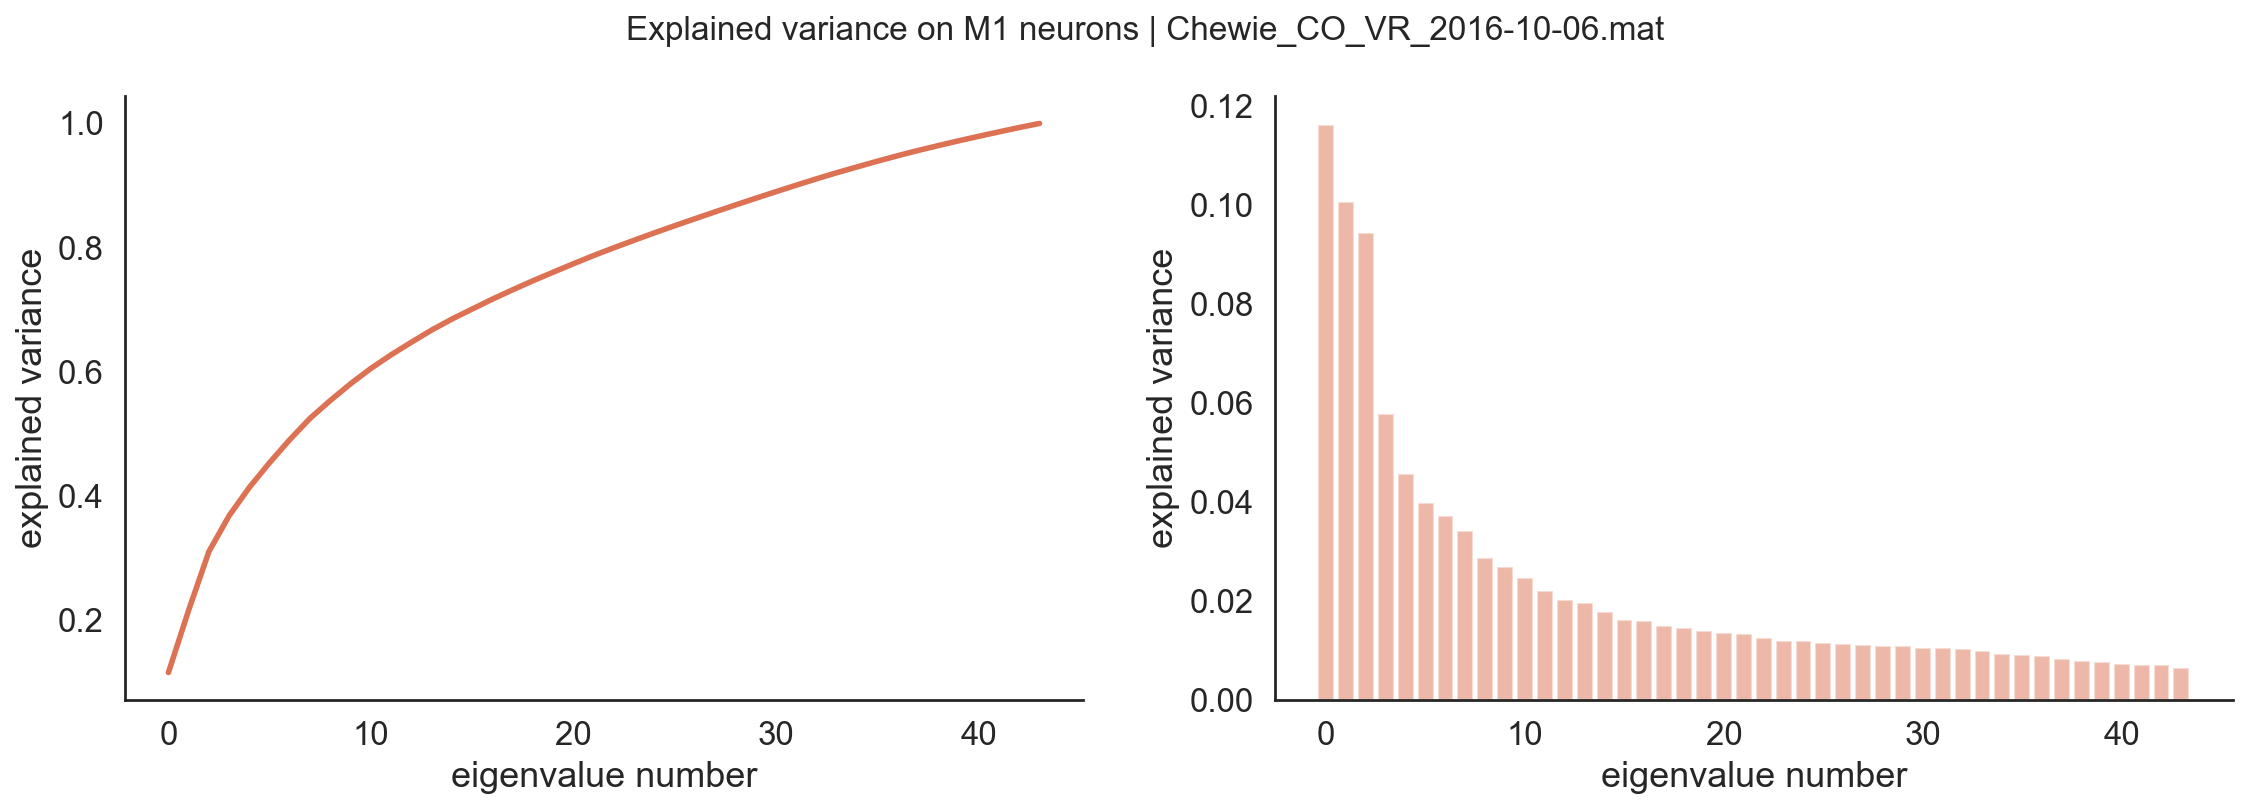

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5), dpi=80)
fig.suptitle(f'Explained variance on M1 neurons | {fname}', fontsize=15)
ax1.plot(m1_var.cumsum(), lw=2.5)
ax1.set_xlabel('eigenvalue number')
ax1.set_ylabel('explained variance')

ax2.bar(range(0, len(m1_var)), m1_var, alpha=0.5, align='center')
ax2.set_xlabel('eigenvalue number')
ax2.set_ylabel('explained variance')
sns.despine();

## 3 Analyse PC weights 

In [31]:
'''
Parameters
'''
binz = np.arange(0, 0.5, 0.005)

### 3.1 Read in cmp files

In [32]:
df_m1_arr  = read_cmp(file_path='/Users/Daphne/Desktop/Chewie Left M1 SN 6250-001474.cmp')
df_pmd_arr = read_cmp(file_path='/Users/Daphne/Desktop/Chewie Left PMd SN 6251-001469.cmp')

### 3.2 Create electrode maps

In [33]:
m1_elecmap  = localize_elecs(df_m1_arr, elecs=range(1,97))
pmd_elecmap = localize_elecs(df_pmd_arr, elecs=range(1,97))

### 3.3 Compare PC weights 

- within M1
- within PMd
- Between M1 & PMd

In [34]:
df = compare_pc_weights(m1_arr=m1_elecmap, m1_ug=td['M1_unit_guide'][0], pmd_arr=pmd_elecmap, pmd_ug=td['PMd_unit_guide'][0], w=w)

In [35]:
df

,distance,w_diff,array,group
0,0.000000,0.043199,M1,same elec
1,5.099020,0.206134,M1,same array
2,5.099020,0.023563,M1,same array
3,1.414214,0.084097,M1,same array
4,1.414214,0.023512,M1,same array
...,...,...,...,...
10148,NaN,0.548914,NaN,other array
10149,NaN,0.139922,NaN,other array
10150,NaN,0.133153,NaN,other array
10151,NaN,0.063849,NaN,other array


In [36]:
df.groupby(['group']).describe()

distance                                                   \
               count     mean       std  min       25%  50%       75%   
group                                                                   
other array      0.0      NaN       NaN  NaN       NaN  NaN       NaN   
same array    5707.0  5.00061  2.333716  1.0  3.162278  5.0  6.708204   
same elec       90.0  0.00000  0.000000  0.0  0.000000  0.0  0.000000   

                        w_diff                                          \
                   max   count      mean       std       min       25%   
group                                                                    
other array        NaN  4356.0  0.098338  0.089709  0.000087  0.033601   
same array   12.041595  5707.0  0.072156  0.055235  0.000008  0.027636   
same elec     0.000000    90.0  0.066884  0.052155  0.001131  0.025400   

                                           
                  50%       75%       max  
group                                      
other array  0.072184  0.136501  0.564991  
same array   0.060553  0.105388  0.278429  
same elec    0.050566  0.094521  0.199151

In [37]:
df.groupby(['array']).describe()

distance                                                         \
         count      mean       std  min       25%       50%       75%   
array                                                                   
M1       946.0  4.554525  2.279065  0.0  3.000000  4.242641  6.082763   
PMd     4851.0  4.994826  2.412590  0.0  3.162278  5.000000  6.708204   

                  w_diff                                                    \
             max   count      mean       std       min       25%       50%   
array                                                                        
M1     10.630146   946.0  0.076287  0.059933  0.000052  0.027387  0.062442   
PMd    12.041595  4851.0  0.071253  0.054183  0.000008  0.027694  0.059968   

                           
            75%       max  
array                      
M1     0.116781  0.278429  
PMd    0.103310  0.278429

In [38]:
df_m1_other = df.loc[df['array'].isin(['M1', np.nan])]
df_pmd_other = df.loc[df['array'].isin(['PMd', np.nan])]

In [39]:
df_m1_other.describe()

,distance,w_diff
count,946.000000,5302.000000
mean,4.554525,0.094404
std,2.279065,0.085575
min,0.000000,0.000052
25%,3.000000,0.032535
50%,4.242641,0.069966
75%,6.082763,0.131840
max,10.630146,0.564991


In [40]:
df_pmd_other.describe()

,distance,w_diff
count,4851.000000,9207.000000
mean,4.994826,0.084067
std,2.412590,0.074408
min,0.000000,0.000008
25%,3.162278,0.030569
50%,5.000000,0.064807
75%,6.708204,0.117266
max,12.041595,0.564991


### 3.4 Plot weight differences 

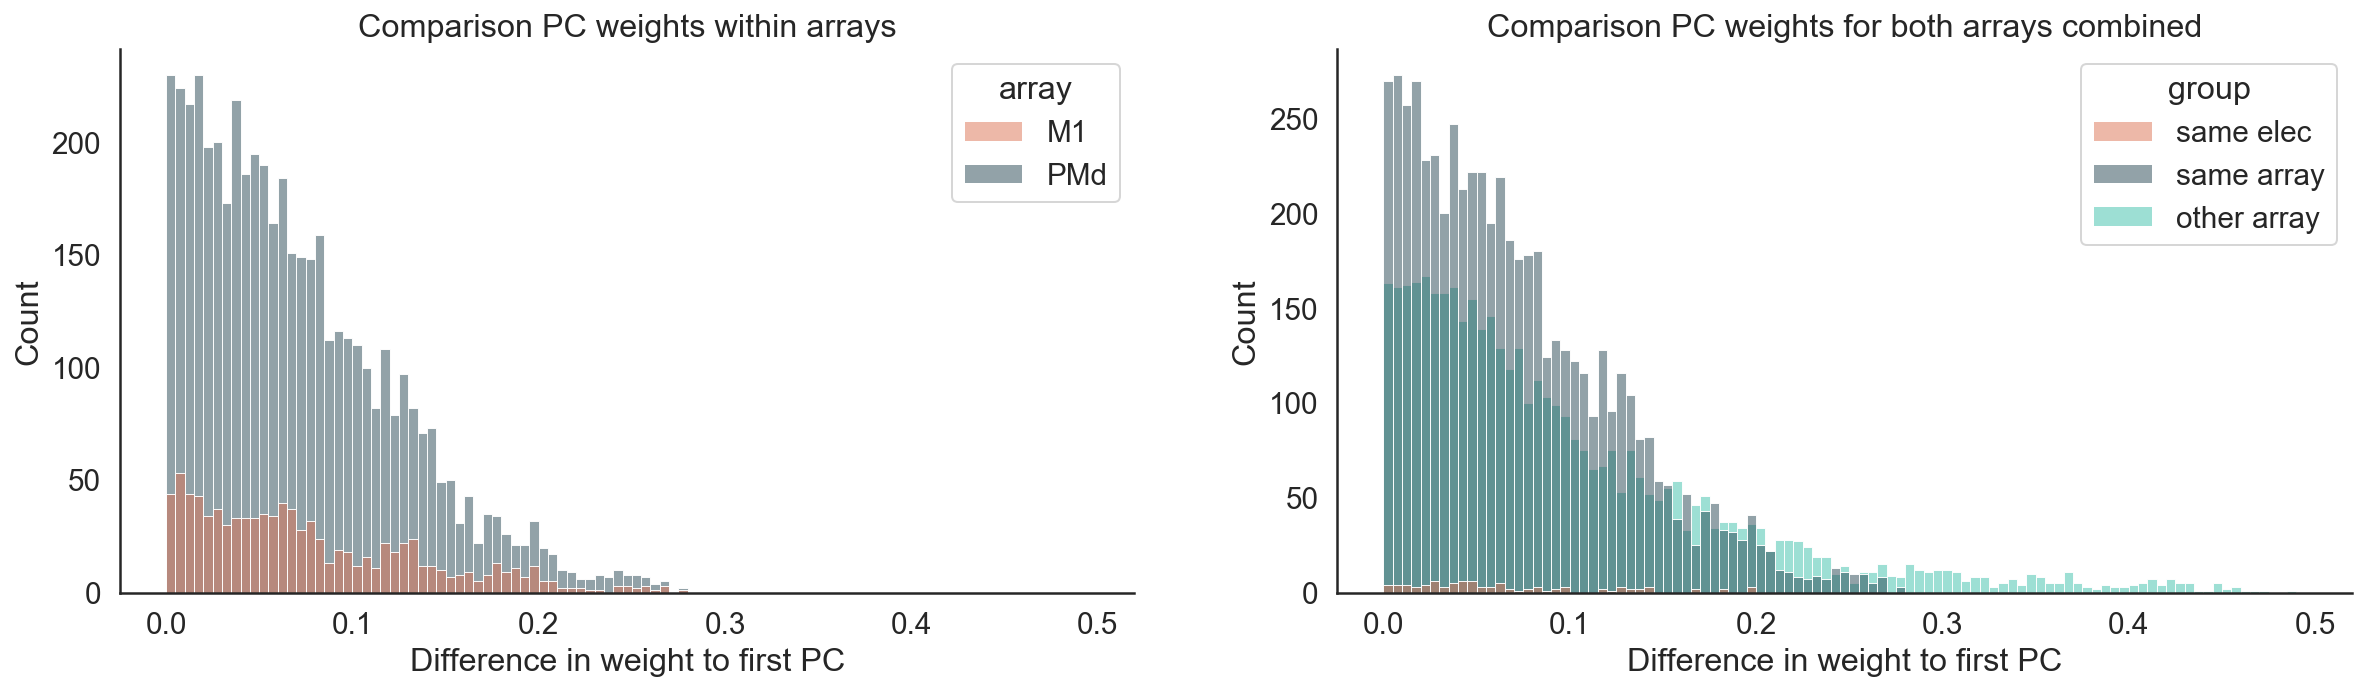

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

sns.histplot(df, x='w_diff', hue='array', bins=binz, stat='count', ax=ax1)
ax1.set_title('Comparison PC weights within arrays')
ax1.set_xlabel('Difference in weight to first PC')
ax1.set_ylabel('Count')

sns.histplot(df, x='w_diff', hue='group', bins=binz, stat='count', ax=ax2)
ax2.set_title('Comparison PC weights for both arrays combined')
ax2.set_xlabel('Difference in weight to first PC')
ax2.set_ylabel('Count')
sns.despine()

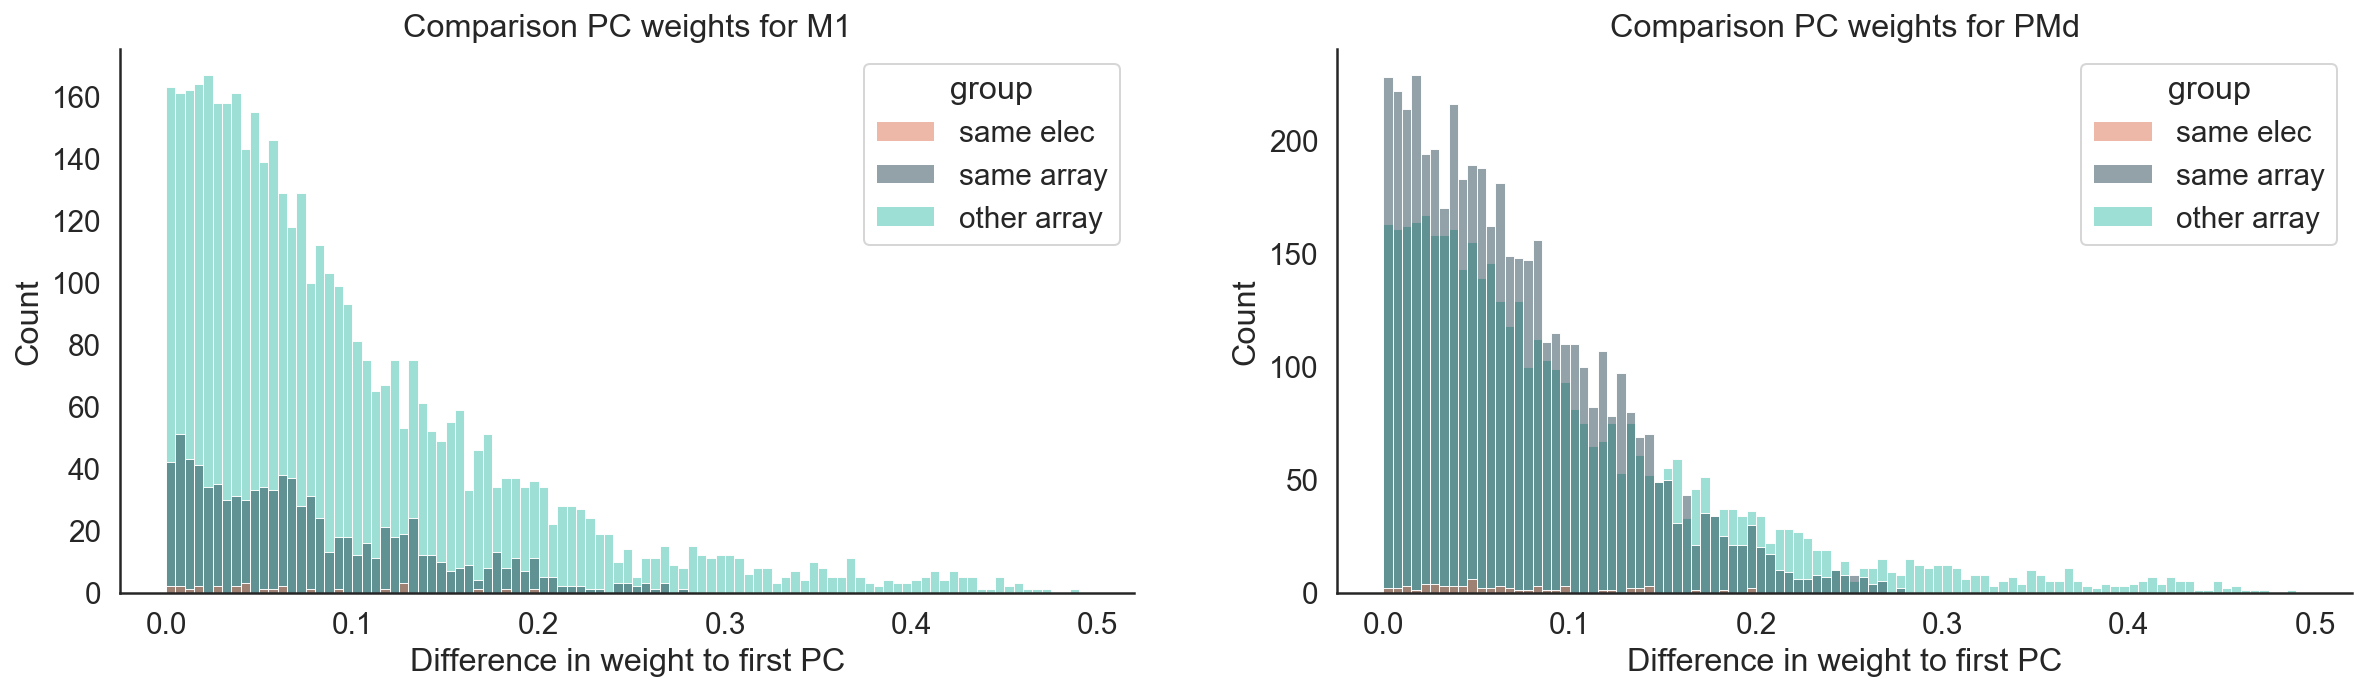

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

sns.histplot(df_m1_other, x='w_diff', hue='group', bins=binz, stat='count', ax=ax1)
ax1.set_title('Comparison PC weights for M1')
ax1.set_xlabel('Difference in weight to first PC')

sns.histplot(df_pmd_other, x='w_diff', hue='group', bins=binz, stat='count', ax=ax2)
ax2.set_title('Comparison PC weights for PMd')
ax2.set_xlabel('Difference in weight to first PC')
sns.despine()

`probability` normalizes counts so that the sum of the bar heights is 1

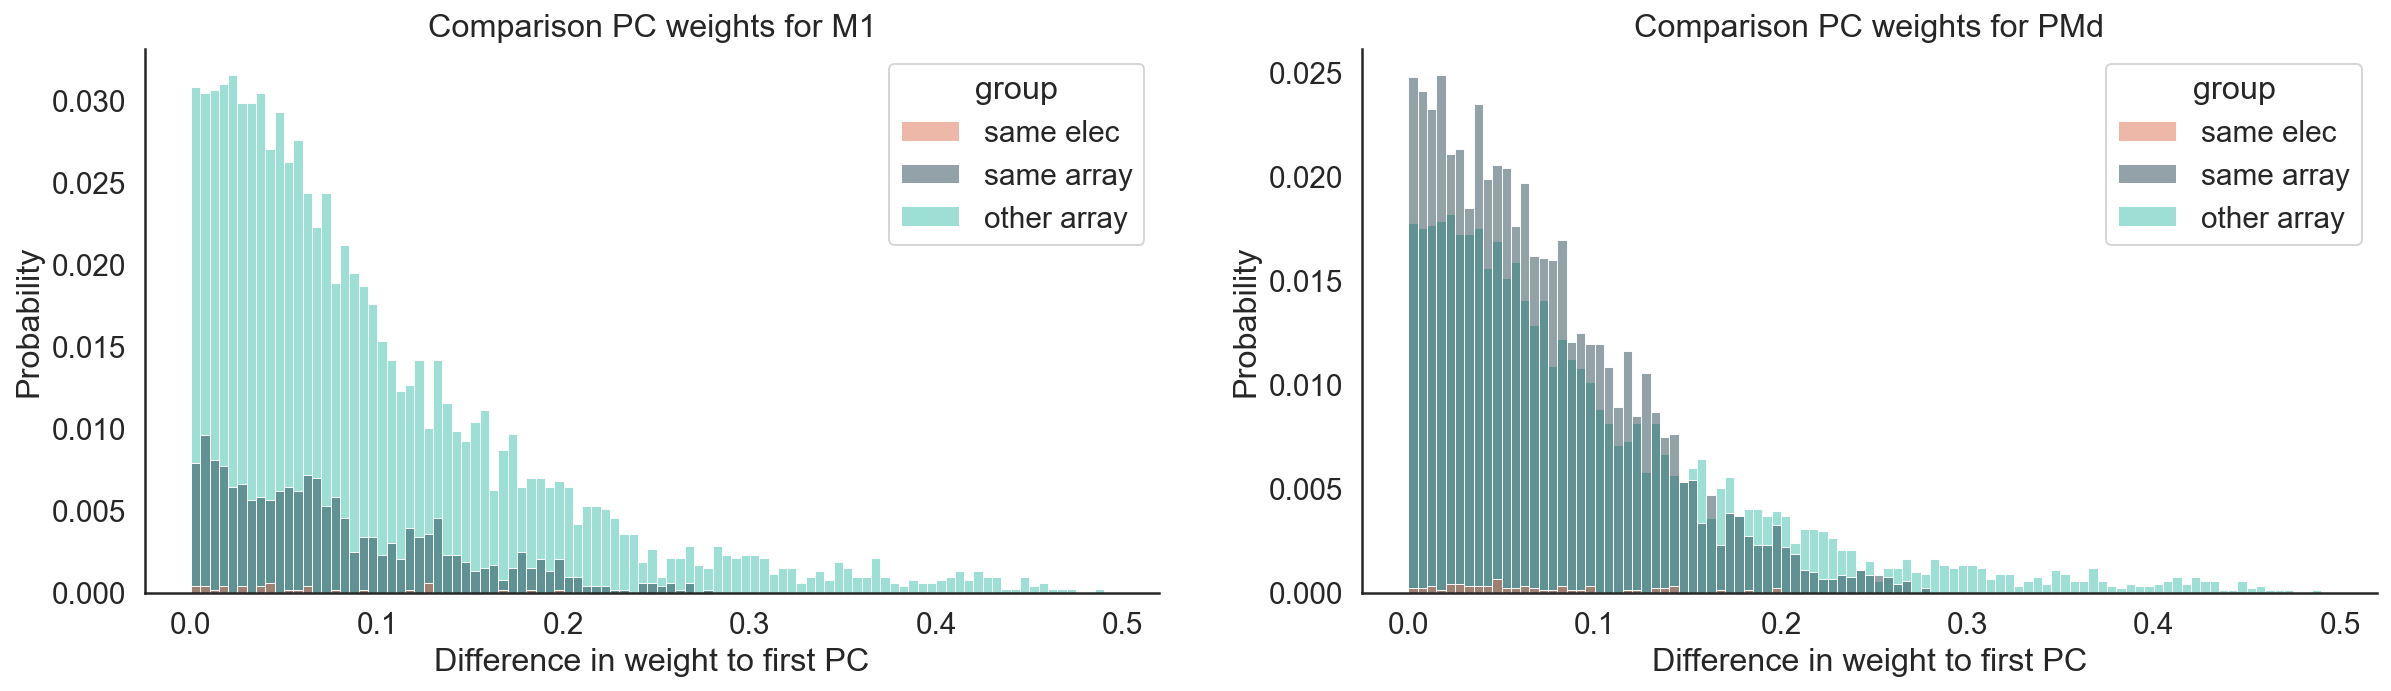

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

sns.histplot(df_m1_other, x='w_diff', hue='group', bins=binz, stat='probability', ax=ax1)
ax1.set_title('Comparison PC weights for M1')
ax1.set_xlabel('Difference in weight to first PC')

sns.histplot(df_pmd_other, x='w_diff', hue='group', bins=binz, stat='probability', ax=ax2)
ax2.set_title('Comparison PC weights for PMd')
ax2.set_xlabel('Difference in weight to first PC')
sns.despine()

In [44]:
df_pmd_other

,distance,w_diff,array,group
946,0.0,0.043199,PMd,same elec
947,6.0,0.206134,PMd,same array
948,6.0,0.023563,PMd,same array
949,7.0,0.084097,PMd,same array
950,7.0,0.023512,PMd,same array
...,...,...,...,...
10148,NaN,0.548914,NaN,other array
10149,NaN,0.139922,NaN,other array
10150,NaN,0.133153,NaN,other array
10151,NaN,0.063849,NaN,other array


### KS statistic on 2 samples PMd

In [45]:
df = df_pmd_other

same_elec = df.loc[df['group'] == 'same elec']['w_diff'].values
same_arr = df.loc[df['group'] == 'same array']['w_diff'].values
other_arr = df.loc[df['group'] == 'other array']['w_diff'].values

p_se_sa, _ = ks_2samp(same_elec, same_arr, alternative='greater', mode='auto')
p_se_oa, _ = ks_2samp(same_elec, other_arr, alternative='greater', mode='auto')
p_sa_oa, _ = ks_2samp(same_arr, other_arr, alternative='greater', mode='auto')

print(f'Same electrode to same array: P = {p_se_sa} \n')
print(f'Same electrode to other array: P = {p_se_oa} \n')
print(f'Same array to other array: P = {p_sa_oa} \n')

Same electrode to same array: P = 0.0879281537176274 

Same electrode to other array: P = 0.1656828020464384 

Same array to other array: P = 0.1262281046970042 



### KS statistic on 2 samples M1

In [46]:
df = df_m1_other

same_elec = df.loc[df['group'] == 'same elec']['w_diff'].values
same_arr = df.loc[df['group'] == 'same array']['w_diff'].values
other_arr = df.loc[df['group'] == 'other array']['w_diff'].values

p_se_sa, _ = ks_2samp(same_elec, same_arr, alternative='greater', mode='asymp')
p_se_oa, _ = ks_2samp(same_elec, other_arr, alternative='greater', mode='asymp')
p_sa_oa, _ = ks_2samp(same_arr, other_arr, alternative='greater', mode='asymp')

print(f'Same electrode to same array: P = {p_se_sa} \n')
print(f'Same electrode to other array: P = {p_se_oa} \n')
print(f'Same array to other array: P = {p_sa_oa} \n')

Same electrode to same array: P = 0.18679724338048598 

Same electrode to other array: P = 0.2316345270890725 

Same array to other array: P = 0.08804135928480572 



### 4. Compare weights on self-manifold with global-manifold

Here, we compare the weight on the self-manifold with the weight on the global-manifold.

The **self-manifold** are the resulting principal components from applying pca to the neurons from array (m1 and pmd separately).

The **global-manifold** are the resulting principal components from applying pca to the neurons on both arrays combined.

This allows us to quantify the difference between the weights for both conditions. 

---

In [304]:
# specify the principal component number 
K = 0

# take the first principal component self-manifold m1
m1_self  = np.array([m1_loadings[:, K]])
# take the first x elements that belong to global-manifold m1
m1_glob = np.array([m1pmd_loadings[0:td.M1_spikes[0].shape[1], K]])

# take the first principal component self-manifold pmd
pmd_self  = np.array([pmd_loadings[:, K]])
# take the last x elements that belong to global-manifold pmd
pmd_glob = np.array([m1pmd_loadings[td.M1_spikes[0].shape[1]:, K]])

# stack weights on self - global
v_self = np.hstack((m1_self, pmd_self))
v_glob = np.hstack((m1_glob, pmd_glob))

# compute correlation between vectors
r = np.corrcoef(v_self, v_glob)[0,1]

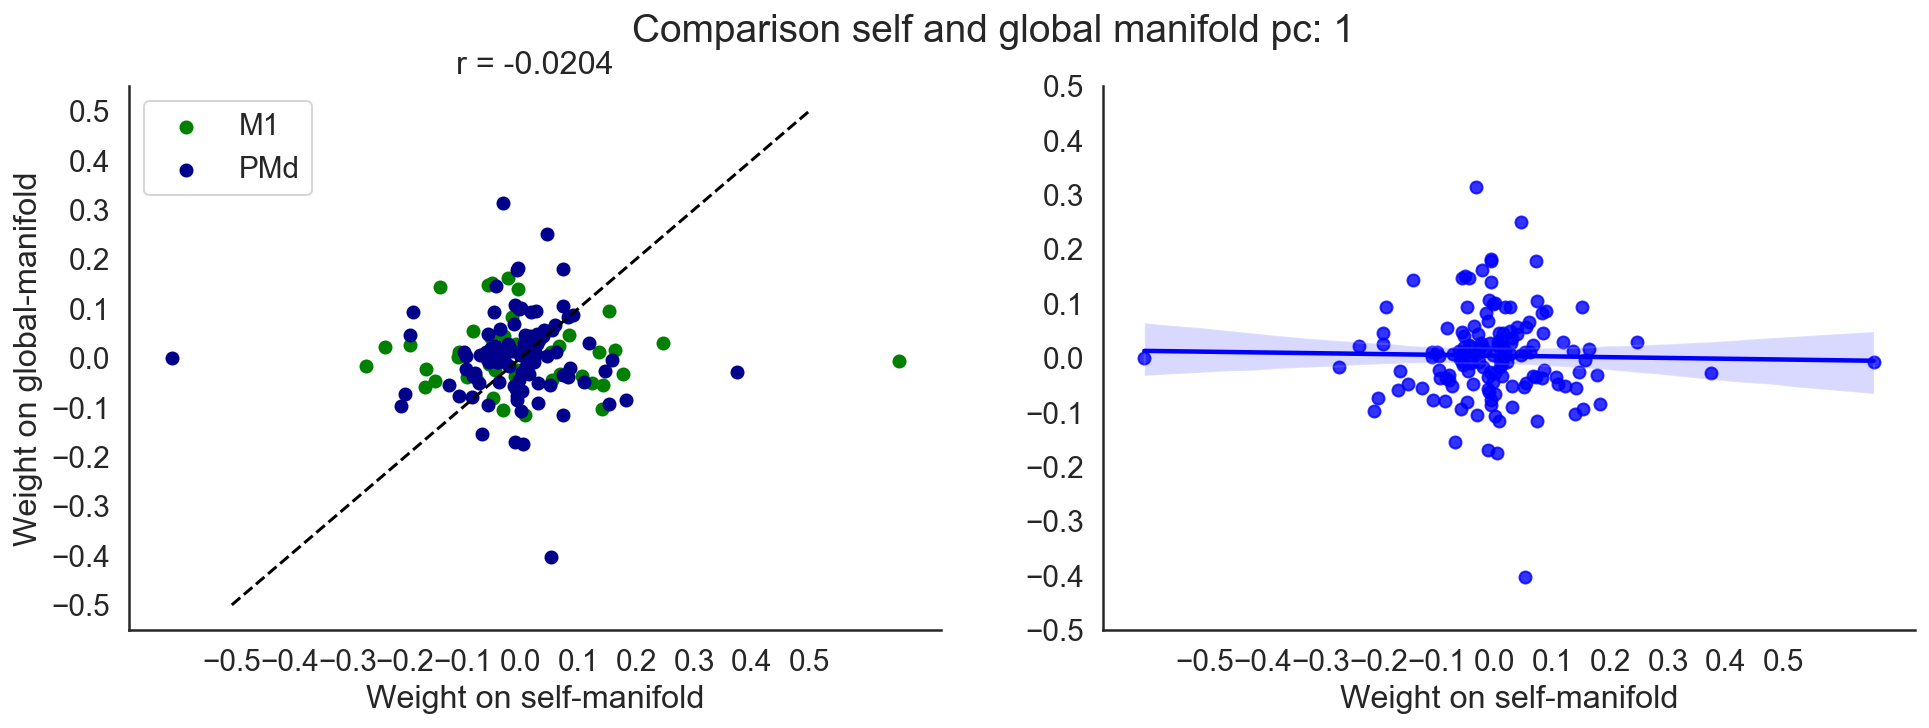

In [305]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle(f'Comparison self and global manifold pc: {K+1}')

ax1.set_title(f'r = {round(r,4)}')
ax1.plot([-0.5, 0.5],[-0.5, 0.5],'k--')
ax1.scatter(m1_self, m1_glob, label='M1', color='g')
ax1.scatter(pmd_self, pmd_glob, label='PMd', color='darkblue')
ax1.set_xlabel('Weight on self-manifold')
ax1.set_ylabel('Weight on global-manifold')
ax1.set_xticks(np.arange(-0.5, 0.6, 0.1))
ax1.set_yticks(np.arange(-0.5, 0.6, 0.1))
ax1.legend()

sns.regplot(v_self, v_glob, color='b', ax=ax2)
ax2.set_xticks(np.arange(-0.5, 0.6, 0.1))
ax2.set_yticks(np.arange(-0.5, 0.6, 0.1))
ax2.set_xlabel('Weight on self-manifold')
sns.despine()

In [306]:
correlations = []

for k in np.arange(0, m1_loadings.shape[0]):
    
    # take the first principal component self-manifold m1
    m1_self  = np.array([m1_loadings[:, k]])
    # take the first x elements that belong to global-manifold m1
    m1_glob = np.array([m1pmd_loadings[0:td.M1_spikes[0].shape[1], k]])

    # take the first principal component self-manifold pmd
    pmd_self  = np.array([pmd_loadings[:, k]])
    # take the last x elements that belong to global-manifold pmd
    pmd_glob = np.array([m1pmd_loadings[td.M1_spikes[0].shape[1]:, k]])

    # stack weights on self - global
    v_self = np.hstack((m1_self, pmd_self))
    v_glob = np.hstack((m1_glob, pmd_glob))

    # compute correlation between vectors
    correlations.append(np.corrcoef(v_self, v_glob)[0,1])

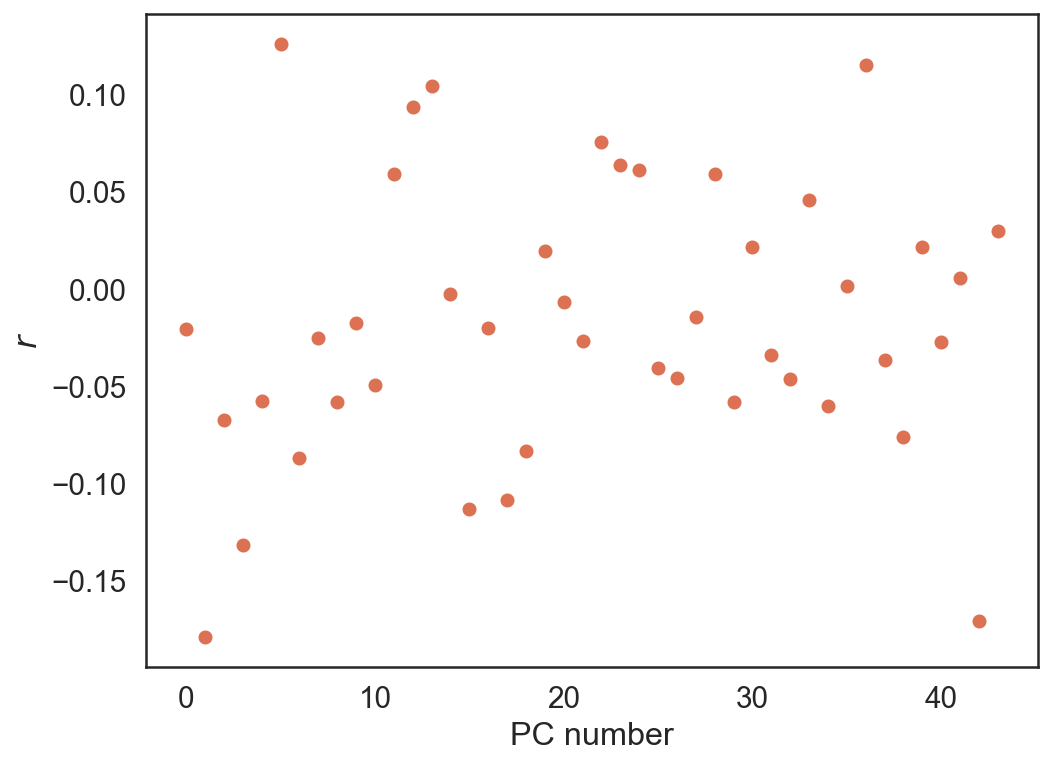

In [307]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.plot(correlations, 'o')
ax.set_xlabel('PC number')
ax.set_ylabel(r'$r$');